In [339]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [394]:
img = np.array(Image.open('swan.jpg').convert('L'))
print(img.shape)

(144, 259)


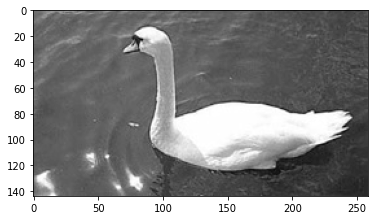

In [395]:
plt.imshow(img,cmap='gray')
plt.show()

In [396]:
sH = np.zeros((5,5))
sH =[
    [1,4,7,4,1],
    [4,16,26,16,4],
    [7,26,41,26,7],
    [4,16,26,16,4],
    [1,4,7,4,1]
]

In [397]:
SH = np.zeros((img.shape[0],img.shape[1]))
SH[0:5,0:5] = sH

In [398]:
H1 = np.fft.fft2(SH)

In [399]:
F = np.fft.fft2(img)

In [400]:
G = H1*F

In [401]:
im = np.fft.ifft(G)

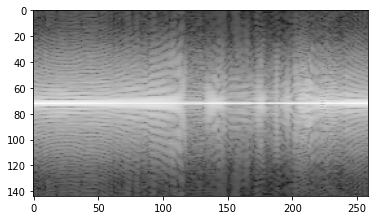

In [402]:
im_shifted = np.fft.fftshift(im)
im_mag_spec = 5*np.log(np.abs(im_shifted))
plt.imshow(im_mag_spec, cmap='gray')
plt.show()

In [403]:
def convolve2D(F, H, fil_shape):
    G = np.zeros((F.shape[0]-fil_shape+1,F.shape[1]-fil_shape+1))
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            G[i,j] = np.sum(np.multiply(F[i:i+fil_shape,j:j+fil_shape],H))
    return G

In [404]:
img.shape

(144, 259)

In [405]:
sH = np.zeros((5,5))
sH = np.zeros((5,5))
sH[0,] = [1,4,7,4,1]
sH[1,] = [4,16,26,16,4]
sH[2,] = [7,26,41,26,7]
sH[3,] = [4,16,26,16,4]
sH[4,] = [1,4,7,4,1]

In [406]:
sH.shape

(5, 5)

In [407]:
# Smooth out an image
G = convolve2D(img, sH,5)

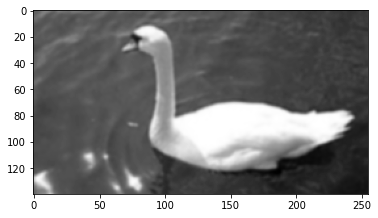

In [408]:
# plt.imshow(img,cmap='gray')
plt.imshow(G,cmap='gray')
plt.show()

In [409]:
Hx = np.zeros((3,3))
Hx[0,:] = [-1,0,1]
Hx[1,:] = [-2,0,2]
Hx[-1,:] = [-1,0,1]
Hx

array([[-1.,  0.,  1.],
       [-2.,  0.,  2.],
       [-1.,  0.,  1.]])

In [410]:
Fx = convolve2D(G, Hx,3)

In [411]:
Hy = np.zeros((3,3))
Hy[0,:] = [1,2,1]
Hy[1,:] = [0,0,0]
Hy[-1,:] = [-1,-2,-1]
Hy

array([[ 1.,  2.,  1.],
       [ 0.,  0.,  0.],
       [-1., -2., -1.]])

In [412]:
Fy = convolve2D(G, Hy,3)

In [413]:
G = np.hypot(Fx,Fy)
G = G/G.max()*255

In [414]:
theta = np.arctan2(Fy,Fx)

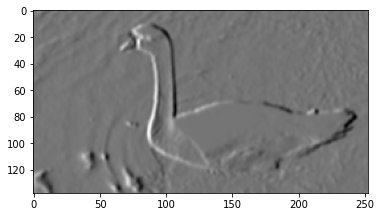

In [415]:
plt.imshow(Fx,cmap='gray')
plt.show()

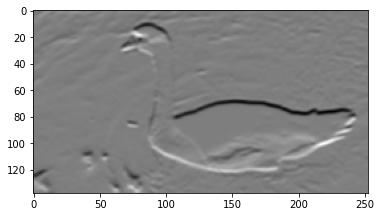

In [416]:
plt.imshow(Fy,cmap='gray')
plt.show()

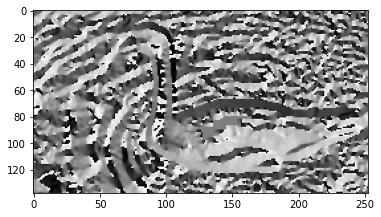

In [417]:
plt.imshow(theta,cmap='gray')
plt.show()

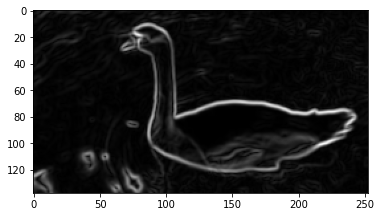

In [418]:
# Gradient intensity
plt.imshow(G,cmap='gray')
plt.show()

In [419]:
theta[0,0]

1.0895134358179426

In [420]:
G[0,0]

3.083423924728076

In [421]:
def nonMaxSuppression(G,theta):
    output = np.zeros((G.shape[0],G.shape[1]))
    orientation = theta *180./np.pi   # radians to degrees
    
    orientation[orientation < 0] += 180 # make all orientations greater than or equal to 0
    rows,cols = G.shape
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            x = 255
            y = 255
            
            if(0 <= orientation[i,j] < 22.5) or (157.5 <= orientation[i,j] <= 180):
                x = G[i,j+1]
                y = G[i,j-1]
            elif (22.5 <= orientation[i,j] < 67.5):
                x = G[i-1,j+1]
                y = G[i+1,j-1]
            elif (67.5 <= orientation[i,j] < 112.5):
                x = G[i-1,j]
                y = G[i+1,j]
            elif (112.5 <= orientation[i,j] < 157.5):
                x = G[i-1,j-1]
                y = G[i+1,j+1]
            
            if(G[i,j] >= x) and (G[i,j] >= y):
                output[i,j] = G[i,j]
            else:
                output[i,j] = 0
                
    return(output)

In [422]:
Gnms = nonMaxSuppression(G,theta)

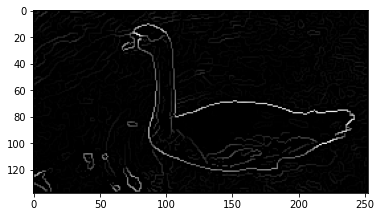

In [423]:
plt.imshow(Gnms,cmap='gray')
plt.show()

In [424]:
np.int(25)

25

In [425]:
def doubleThreshold(Gnms, low_thresh=0.05, high_thresh=0.09):
    highThresh = Gnms.max()*high_thresh
    lowThresh = highThresh*low_thresh
    
    rows,cols = Gnms.shape
    output = np.zeros((rows,cols),dtype=np.int32)
    strong_val = np.int32(255)
    weak_val = np.int32(25)
    
    
    str_idx_row, str_idx_col = np.where(Gnms >= highThresh)
    irr_idx_row, irr_idx_col = np.where(Gnms < lowThresh)
    
    weak_idx_row, weak_idx_col = np.where((Gnms <= highThresh) & (Gnms >= lowThresh))
    
    output[str_idx_row, str_idx_col] = strong_val
    output[weak_idx_row, weak_idx_col] = weak_val
    
    return(output)
    
    
    
    

In [426]:
G_dThresh = doubleThreshold(Gnms)

In [427]:
G_dThresh[1,45]

25

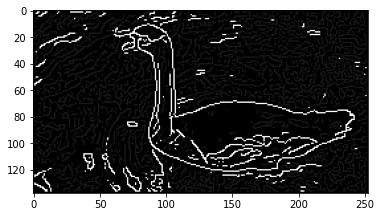

In [428]:
plt.imshow(G_dThresh,cmap='gray')
plt.show()

In [429]:
def hysteresis(G_dThresh,weak_val,strong_val=255):
    rows,cols = G_dThresh.shape
    for i in range(0,rows-1):
        for j in range(0,cols-1):
            if (G_dThresh[i,j]== weak_val):
                try:
                    if ((G_dThresh[i,j-1]== strong_val) or (G_dThresh[i,j+1]== strong_val) or (G_dThresh[i-1,j]== strong_val) or (G_dThresh[i+1,j]== strong_val) or (G_dThresh[i-1,j+1]== strong_val) or (G_dThresh[i-1,j-1]== strong_val) or (G_dThresh[i+1,j+1]== strong_val) or (G_dThresh[i+1,j-1]== strong_val)):
                        G_dThresh[i,j] = strong_val
                    else:
                        G_dThresh[i,j] = 0
                except IndexError as e:
                    pass
                    
           
    return(G_dThresh)

In [430]:
canny_im = hysteresis(np.asarray(G_dThresh),25)

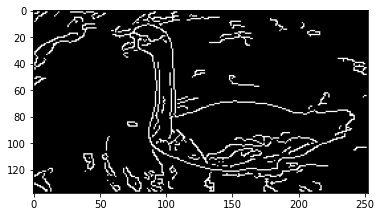

In [431]:
# print(G_dThresh.shape)
plt.imshow(canny_im,cmap='gray')
plt.show()